## Monthly Climate/Ocean Indices from Physical Sciences Laboratory (PSL), NOAA

### Ocean Time-series: ENSO Indices

- Source: NOAA Extended Reconstructed SST V5
- Temporal Resolution: Monthly  
- Duration: Jan 1950 to Sep 2025
- Units: ℃
- Climatology: 1981-2010
- Temporal Coverage: Jan 1950 to Sep 2025

1) Niño 1+2 region 0N-10S, 90W-80W
   - https://psl.noaa.gov/data/correlation/nina1.anom.csv

2) Niño 3 region (5N-5S,150W-90W) 

   - https://psl.noaa.gov/data/correlation/nina3.anom.csv

3) Niño 3.4 region (5N-5S, 170-120W)
   - https://psl.noaa.gov/data/correlation/nina34.anom.csv

4) Nino 4 (5N-5S, 160E-150W)
   -  https://psl.noaa.gov/data/correlation/nina4.anom.csv

5) Multivariate ENSO Index (MEI V2): `SST` and `5 atmospheric variables` are combined using `EOFs` of the `tropical Pacific` to create a `single index`. 

    - https://psl.noaa.gov/data/correlation/meiv2.csv

6) Oceanic Niño; Index (ONI) V2: The ONI is the NOAA official index indicating the state of the ENSO.  [Niño 3.4 region (5°N-5°S, 120°-170°W)]

   - https://psl.noaa.gov/data/correlation/oni.csv

7) Dipole Mode Index (DMI): 

Region:
   - Western equatorial Indian Ocean (50E-70E and 10S-10N) 
   - South eastern equatorial Indian Ocean (90E-110E and 10S-0N)

   - https://psl.noaa.gov/data/timeseries/month/data/dmi.had.long.csv


8) Pacific Warm-Pool Time-series: Area averaged SST [60E-170E, 15S-15N] 
     - Dataset: NOAA ERSSTV5 1948-present.

     - https://psl.noaa.gov/data/timeseries/month/data/pacwarmpool.ersst.csv

9) Bivariate EnSo Timeseries: An ENSO index based on ocean (SST) and atmospheric (SOI) data.

    - https://psl.noaa.gov/data/correlation/censo.csv


10)  Real-time Multivariate MJO (RMM) index: standard for historical daily data from 1974 to near-real-time.

     - https://psl.noaa.gov/mjo/mjoindex/omi.1x.txt

     - RMM1/RMM2 are PCs of OLR/U850/U200 anomalies. 
     
     - Amplitude >1 = active MJO; phases indicate propagation.

     - omi.1x.txt has four column and need parse convert to CSV: year, month, day, PC1, PC2, phase, amplitude.

## Preprocess the Predictors

- Gather monthly indices

- Extract to 1981–2024

- Create appropriate candidate features and Lagged Indices without leakage:  

    - 3 month lead
    - 2 month lead
    - 1 month lead 

OND model (issued Sep 30): candidate features

 - n12_JAS, n12_AS, n12_Sep

 - n3_JAS, n3_AS,  n3_Sep

 - n34_JAS, n34_AS,  n34_Sep

 - n4_JAS, n4_AS, n4_Sep

 - meiv2_JAS, meiv2_AS, meiv2_Sep

 - oni_JAS, oni_AS, oni_Sep

 - pacwarmpool_JAS, pacwarmpool_AS, pacwarmpool_Sep

 - censo_JAS, censo_AS, censo_Sep 

 - dmi_JAS, dmi_AS, dmi_Sep

 - season persistence (e.g., MJJ, JJA, JAS rainfall anomaly)


MAM model (issued Feb 28): candidate features


- n12_NDJ, n12_DJ, n12_Feb

- n3_NDJ, n3_DJ, n3_Feb

- n34_NDJ, n34_DJ, n34_Feb
 
- n4_NDJ, n4_DJ, n4_Feb 

- meiv2_NDJ, meiv2_DJ, meiv2_Feb

- oni_NDJ, oni_DJ, oni_Feb

- pacwarmpool_NDJ, pacwarmpool_DJ, pacwarmpool_Feb,

- censo_NDJ, censo_DJ, censo_Feb, 

- dmi_NDJ, dmi_DJ, dmi_Feb
        
- season persistence (OND, NDJ, DJF anomaly) 

## Import Libraries

In [ ]:
import os, glob, math, re, io, warnings, requests, yaml
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import regionmask
from shapely.geometry import mapping
from tqdm import tqdm

xr.set_options(keep_attrs=True)

# Set working directory 

os.chdir("C:\\Users\\yonas\\Documents\\ICPAC\\ea_seasonal_pred\\seasonal-ml-pred")

# Paths (matches your repo)
RAW_DIR        = "data/raw/chirps_monthly_global"
PROCESSED_DIR  = "data/processed"
EXTERNAL_DIR   = "data/external/indices"
LOGS_DIR       = "reports/logs"

os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(EXTERNAL_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

# Project settings
START_YEAR, END_YEAR = 1981, 2024
CLIM_START, CLIM_END = 1991, 2020

# Download switches (set to False if you already have files)
DOWNLOAD_CHIRPS = True
DOWNLOAD_INDICES = True

## Defining the Paths

In [2]:
import os, io, re, warnings, requests
import numpy as np
import pandas as pd

EXTERNAL_DIR  = "data/external/indices"
PROCESSED_DIR = "data/processed"
os.makedirs(EXTERNAL_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Set working directory 
os.chdir("C:\\Users\\yonas\\Documents\\ICPAC\\ea_seasonal_pred\\seasonal-ml-pred")

# Time window you care about
START_YEAR, END_YEAR = 1981, 2024

# Your curated PSL sources (monthly, mostly anomalies; units often °C)
SOURCES = {
    # ENSO SST regions
    "nino12":  "https://psl.noaa.gov/data/correlation/nina1.anom.csv",
    "nino3":   "https://psl.noaa.gov/data/correlation/nina3.anom.csv",
    "nino34":  "https://psl.noaa.gov/data/correlation/nina34.anom.csv",
    "nino4":   "https://psl.noaa.gov/data/correlation/nina4.anom.csv",
    # MEI v2
    "meiv2":   "https://psl.noaa.gov/data/correlation/meiv2.csv",
    # ONI (NOAA official 3-mo running N3.4 anomaly)
    "oni":     "https://psl.noaa.gov/data/correlation/oni.csv",
    # IOD / DMI (HadISST)
    "dmi":     "https://psl.noaa.gov/data/timeseries/month/data/dmi.had.long.csv",
    # Pacific Warm Pool (ERSSTV5)
    "pacwarmpool": "https://psl.noaa.gov/data/timeseries/month/data/pacwarmpool.ersst.csv",
    # Bivariate ENSO index
    "censo":   "https://psl.noaa.gov/data/correlation/censo.csv",
}


## Downloading and parsers to handle PSL CSV

In [29]:
def _fetch_text(url: str, timeout: int = 90) -> str:
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    return r.text

def _clean_df(df: pd.DataFrame) -> pd.DataFrame:
    # drop all-empty cols/rows, strip names
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    df = df.dropna(how="all")
    return df

def _parse_wide_year_months(df: pd.DataFrame) -> pd.Series:
    """
    Wide table: one row per YEAR and columns JAN..DEC (sometimes also 'ANNUAL').
    """
    df = _clean_df(df)
    # Normalize month names
    month_alias = {
        'JAN':'1','FEB':'2','MAR':'3','APR':'4','MAY':'5','JUN':'6',
        'JUL':'7','AUG':'8','SEP':'9','OCT':'10','NOV':'11','DEC':'12'
    }
    # Guess year column
    ycol = None
    for c in df.columns:
        if re.fullmatch(r"(?i)year|yr|yyyy", c):
            ycol = c
            break
    if ycol is None:
        # sometimes first column is Year
        ycol = df.columns[0]
    # Keep month columns only
    mcols = [c for c in df.columns if c.upper()[:3] in month_alias]
    if not mcols:
        raise ValueError("No JAN..DEC columns found in wide table.")
    melted = []
    for _, row in df.iterrows():
        y = int(row[ycol])
        for mc in mcols:
            mnum = int(month_alias[mc.upper()[:3]])
            val = pd.to_numeric(row[mc], errors="coerce")
            melted.append({"date": pd.Timestamp(y, mnum, 1), "value": val})
    ser = (pd.DataFrame(melted)
             .dropna(subset=["value"])
             .set_index("date")["value"]
             .sort_index()
             .asfreq("MS"))
    return ser

def _parse_long_year_month_value(df: pd.DataFrame) -> pd.Series:
    """
    Long tidy table with YEAR, MONTH (or MON) and a value/ANOM column.
    """
    df = _clean_df(df)
    cols = {c.lower(): c for c in df.columns}
    # Try to find year & month col names
    year_c = next((cols[k] for k in ["year","yr","yyyy"] if k in cols), None)
    mon_c  = next((cols[k] for k in ["month","mon","mm"] if k in cols), None)
    if year_c is None or mon_c is None:
        raise ValueError("YEAR/MONTH columns not found in long table.")

    # Choose a value column by priority
    val_candidates = [k for k in df.columns if k not in [year_c, mon_c]]
    # Prefer typical names
    pref = [c for c in val_candidates if re.search(r"(?i)value|anom|index|dmi|mei|oni|sst", c)]
    val_c = pref[0] if pref else val_candidates[0]

    tmp = df[[year_c, mon_c, val_c]].copy()
    tmp.columns = ["year", "month", "value"]
    tmp["date"] = pd.to_datetime(dict(year=tmp["year"].astype(int),
                                      month=tmp["month"].astype(int),
                                      day=1), errors="coerce")
    ser = (tmp.dropna(subset=["date"])
              .set_index("date")["value"]
              .astype(float)
              .sort_index()
              .asfreq("MS"))
    return ser

def _parse_single_date_value(df: pd.DataFrame) -> pd.Series:
    """
    Two-column style: first column is a date (YYYY-MM or YYYY-MM-DD), second is value.
    """
    df = _clean_df(df)
    # choose date-like column
    date_c = None
    for c in df.columns:
        # Try datetime conversion on a sample
        try:
            ts = pd.to_datetime(df[c], errors="coerce")
            if ts.notna().mean() > 0.8:
                date_c = c
                break
        except Exception:
            continue
    if date_c is None:
        raise ValueError("No parseable date column found.")
    # choose value column (first numeric other than date)
    val_c = None
    for c in df.columns:
        if c == date_c:
            continue
        if pd.to_numeric(df[c], errors="coerce").notna().mean() > 0.8:
            val_c = c
            break
    if val_c is None:
        raise ValueError("No numeric value column found.")

    ser = (pd.DataFrame({
                "date": pd.to_datetime(df[date_c], errors="coerce"),
                "value": pd.to_numeric(df[val_c], errors="coerce")
            })
            .dropna(subset=["date","value"])
            .set_index("date")["value"]
            .sort_index())

    # Normalize to month-start - fix the period conversion
    ser.index = pd.to_datetime(ser.index.to_period("M").to_timestamp())
    ser = ser.asfreq("MS")
    return ser

def parse_psl_csv_text(txt: str) -> pd.Series:
    """
    Try multiple parsers to handle PSL CSV flavors:
    - comment lines (#) ignored
    - wide (YEAR + JAN..DEC)
    - long (YEAR, MONTH, VALUE)
    - single date/value columns
    Returns monthly Series indexed by Timestamp (MS).
    """
    # Load with comment skipping and flexible parser
    df = pd.read_csv(io.StringIO(txt), comment="#", skip_blank_lines=True)
    if df.shape[1] >= 13 and any(m in [c.upper()[:3] for c in df.columns] for m in ["JAN","FEB","MAR"]):
        # Wide monthly table
        try:
            return _parse_wide_year_months(df)
        except Exception as e:
            warnings.warn(f"Wide parse failed: {e}")
    # Try long YEAR/MON/value
    try:
        return _parse_long_year_month_value(df)
    except Exception:
        pass
    # Try date + value
    try:
        return _parse_single_date_value(df)
    except Exception as e:
        raise ValueError(f"CSV did not match known formats: {e}")

def load_or_download_indices(sources: dict, download: bool = True) -> dict:
    out = {}
    for key, url in sources.items():
        cache = os.path.join(EXTERNAL_DIR, f"{key}_monthly.csv")
        if download:
            try:
                txt = _fetch_text(url)
                ser = parse_psl_csv_text(txt)
                # Drop gross missing sentinels if any
                ser = ser.replace([-99, -99.9, -9.9e1, -999, -9999], np.nan)
                # Save normalized cache
                ser.to_frame("value").to_csv(cache, index_label="date")
            except Exception as e:
                warnings.warn(f"Download/parsing failed for {key}: {e}")
                if os.path.exists(cache):
                    ser = pd.read_csv(cache, parse_dates=["date"]).set_index("date")["value"]
                else:
                    raise
        else:
            ser = pd.read_csv(cache, parse_dates=["date"]).set_index("date")["value"]

        # Standardize: month-start, sorted, float
        ser.index = ser.index.to_period("M").to_timestamp()
        ser = ser.sort_index().asfreq("MS").astype(float)
        out[key] = ser
    return out

indices = load_or_download_indices(SOURCES, download=True)

# Quick sanity peek
{k: (v.index.min(), v.index.max(), f"{v.isna().mean():.2%} NaN") for k, v in indices.items()}

{'nino12': (Timestamp('1948-01-01 00:00:00'),
  Timestamp('2025-12-01 00:00:00'),
  '2.88% NaN'),
 'nino3': (Timestamp('1948-01-01 00:00:00'),
  Timestamp('2025-12-01 00:00:00'),
  '2.88% NaN'),
 'nino34': (Timestamp('1948-01-01 00:00:00'),
  Timestamp('2025-12-01 00:00:00'),
  '2.88% NaN'),
 'nino4': (Timestamp('1948-01-01 00:00:00'),
  Timestamp('2025-12-01 00:00:00'),
  '2.88% NaN'),
 'meiv2': (Timestamp('1979-01-01 00:00:00'),
  Timestamp('2025-12-01 00:00:00'),
  '1.24% NaN'),
 'oni': (Timestamp('1950-01-01 00:00:00'),
  Timestamp('2025-12-01 00:00:00'),
  '0.55% NaN'),
 'dmi': (Timestamp('1870-01-01 00:00:00'),
  Timestamp('2025-12-01 00:00:00'),
  '0.43% NaN'),
 'pacwarmpool': (Timestamp('1854-01-01 00:00:00'),
  Timestamp('2025-12-01 00:00:00'),
  '0.15% NaN'),
 'censo': (Timestamp('1948-01-01 00:00:00'),
  Timestamp('2025-12-01 00:00:00'),
  '1.28% NaN')}

## Verify the Download

In [30]:
# Print only the key of the indices
for k in indices.keys():
    print(k)



nino12
nino3
nino34
nino4
meiv2
oni
dmi
pacwarmpool
censo


## Copy the indices data frame

In [31]:
n12 = indices["nino12"].copy()
n3 = indices["nino3"].copy()
n34 = indices["nino34"].copy()
n4 = indices["nino4"].copy()
meiv2 = indices["meiv2"].copy()
oni = indices["oni"].copy()
pacwarmpool = indices["pacwarmpool"].copy()
censo = indices["censo"].copy()
dmi = indices["dmi"].copy()

## Select the time period

In [32]:
n12 = n12.loc["1981-01": f"{END_YEAR}-12"]
n3 = n3.loc["1981-01": f"{END_YEAR}-12"]
n34 = n34.loc["1981-01": f"{END_YEAR}-12"]
n4 = n4.loc["1981-01": f"{END_YEAR}-12"]
meiv2 = meiv2.loc["1981-01": f"{END_YEAR}-12"]
oni = oni.loc["1981-01": f"{END_YEAR}-12"]
pacwarmpool = pacwarmpool.loc["1981-01": f"{END_YEAR}-12"]
censo = censo.loc["1981-01": f"{END_YEAR}-12"]
dmi = dmi.loc["1981-01": f"{END_YEAR}-12"]

## Convert to the data frame

In [ ]:

df_indices = pd.DataFrame({
    "n12": n12,
    "n3": n3,
    "n34": n34,
    "n4": n4,
    "meiv2": meiv2,
    "oni": oni,
    "pacwarmpool": pacwarmpool,
    "censo": censo,
    "dmi": dmi
})

df_indices


,n12,n3,n34,n4,meiv2,oni,pacwarmpool,censo,dmi
date,,,,,,,,,
1981-01-01,-1.50,-0.71,-0.36,-0.13,-0.36,-0.26,-0.299,-0.26,-0.201
1981-02-01,-1.17,-0.88,-0.64,-0.17,-0.23,-0.50,-0.332,-0.05,-0.024
1981-03-01,-0.55,-0.59,-0.64,-0.17,0.33,-0.47,-0.229,0.82,0.027
1981-04-01,-0.73,-0.52,-0.53,-0.52,0.43,-0.37,-0.358,0.18,0.092
1981-05-01,-0.77,-0.54,-0.57,-0.56,-0.24,-0.26,-0.231,-0.36,-0.018
...,...,...,...,...,...,...,...,...,...
2024-08-01,-0.42,-0.29,-0.12,0.41,-0.73,-0.11,0.635,-0.63,0.267
2024-09-01,-0.75,-0.20,-0.26,0.15,-0.65,-0.21,0.640,0.11,0.115
2024-10-01,-0.32,-0.16,-0.27,0.12,-0.52,-0.26,0.654,-0.48,-0.196


## Check for any missing values

In [ ]:
df_indices.isna().sum()

n12            0
n3             0
n34            0
n4             0
meiv2          0
oni            0
pacwarmpool    0
censo          0
dmi            0
dtype: int64

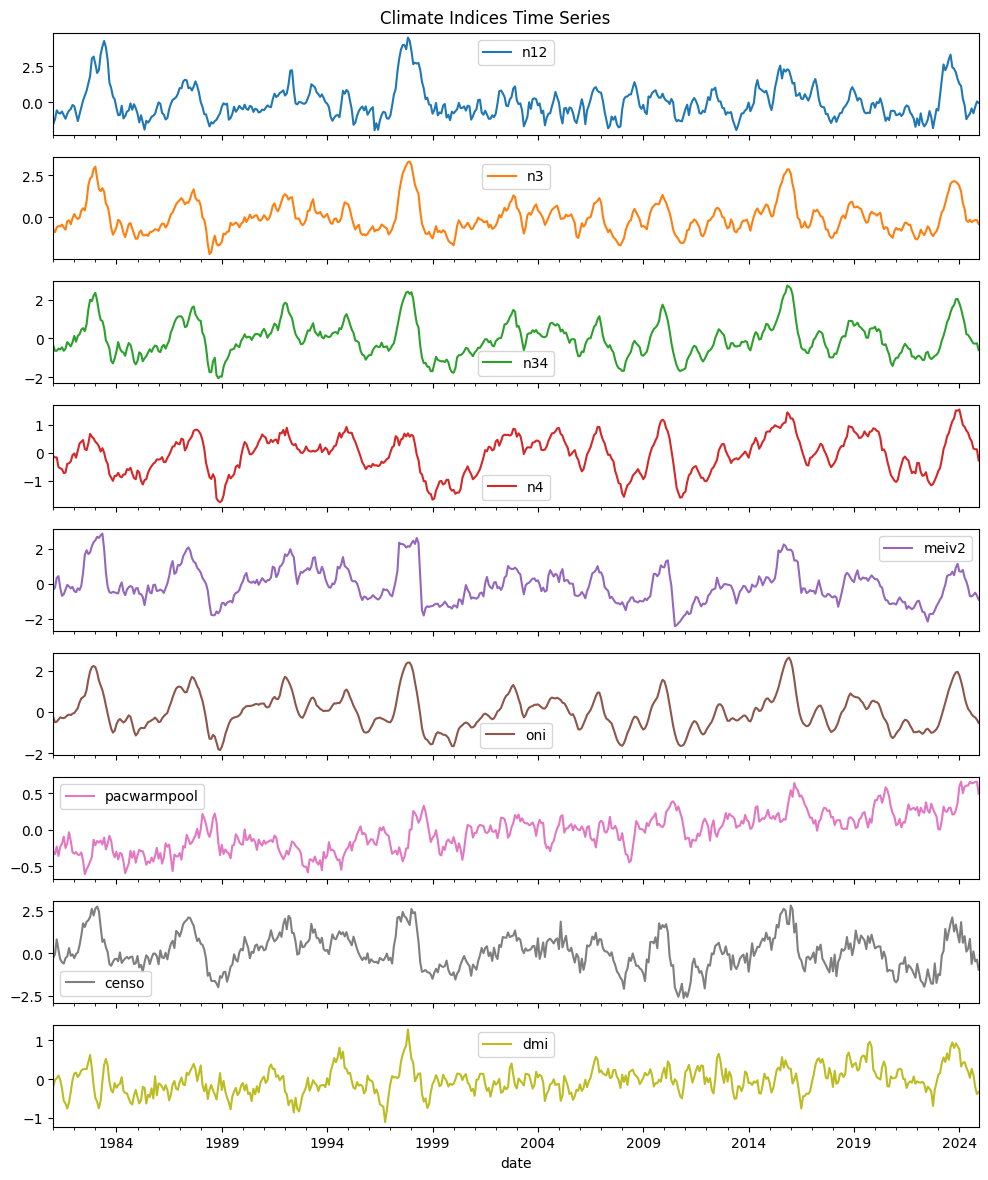

In [35]:
# Plot the indices to visualize trends
import matplotlib.pyplot as plt
df_indices.plot(subplots=True, figsize=(10, 12), title="Climate Indices Time Series")
plt.tight_layout()
plt.show()


## Check and fix the datetime

In [36]:
def to_month_start(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Ensure datetime-like index
    out.index = pd.to_datetime(out.index, errors="coerce")
    # Anchor to the START of each month using Period->Timestamp
    out.index = out.index.to_period("M").to_timestamp(how="start")
    # Ensure a complete monthly index (MonthStart) and keep missing months as NaN
    out = out.sort_index().asfreq("MS")
    return out

df_indices = to_month_start(df_indices)
df_indices.index.freq  # should be <MonthBegin>

<MonthBegin>

In [37]:
df_indices

,n12,n3,n34,n4,meiv2,oni,pacwarmpool,censo,dmi
date,,,,,,,,,
1981-01-01,-1.50,-0.71,-0.36,-0.13,-0.36,-0.26,-0.299,-0.26,-0.201
1981-02-01,-1.17,-0.88,-0.64,-0.17,-0.23,-0.50,-0.332,-0.05,-0.024
1981-03-01,-0.55,-0.59,-0.64,-0.17,0.33,-0.47,-0.229,0.82,0.027
1981-04-01,-0.73,-0.52,-0.53,-0.52,0.43,-0.37,-0.358,0.18,0.092
1981-05-01,-0.77,-0.54,-0.57,-0.56,-0.24,-0.26,-0.231,-0.36,-0.018
...,...,...,...,...,...,...,...,...,...
2024-08-01,-0.42,-0.29,-0.12,0.41,-0.73,-0.11,0.635,-0.63,0.267
2024-09-01,-0.75,-0.20,-0.26,0.15,-0.65,-0.21,0.640,0.11,0.115
2024-10-01,-0.32,-0.16,-0.27,0.12,-0.52,-0.26,0.654,-0.48,-0.196


## Features Enginerrign 

- OND

   - {index}_JAS, {index}_AS, {index}_Sep

- MAM 

  - {index}_NDJ, {index}_DJ, {index}_Feb



In [38]:
def _grab(ser: pd.Series, dates: list[pd.Timestamp]) -> pd.Series:
    """Return values at specific dates (preserving order), possibly containing NaNs."""
    return ser.reindex(dates)

def features_OND_all(df: pd.DataFrame, y0: int, y1: int) -> pd.DataFrame:
    """
    Issuance: end of Sep (use JAS, AS, Sep for each predictor).
    For each column 'X', create: X_JAS, X_AS, X_Sep.
    """
    recs = []
    for y in range(y0, y1 + 1):
        J, A, S = pd.Timestamp(y, 7, 1), pd.Timestamp(y, 8, 1), pd.Timestamp(y, 9, 1)
        # Require at least Sep present for this year; if not, skip this season-year entirely
        if S not in df.index:
            continue
        rec = {"season_year": y}
        for col in df.columns:
            ser = df[col]
            vJAS = _grab(ser, [J, A, S]).mean(skipna=False)  # strict: NaN if any month missing
            vAS  = _grab(ser, [A, S]).mean(skipna=False)
            vSep = ser.reindex([S]).iloc[0] if S in ser.index else np.nan
            rec[f"{col}_JAS"] = vJAS
            rec[f"{col}_AS"]  = vAS
            rec[f"{col}_Sep"] = vSep
        recs.append(rec)
    out = pd.DataFrame(recs).set_index("season_year").sort_index()
    return out

def features_MAM_all(df: pd.DataFrame, y0: int, y1: int) -> pd.DataFrame:
    """
    Issuance: end of Feb (use NDJ, DJ, Feb around year y) for each predictor.
    For each column 'X', create: X_NDJ, X_DJ, X_Feb.
    """
    recs = []
    for y in range(y0, y1 + 1):
        prev = y - 1
        N, D, J, F = pd.Timestamp(prev, 11, 1), pd.Timestamp(prev, 12, 1), pd.Timestamp(y, 1, 1), pd.Timestamp(y, 2, 1)
        # Require at least Feb present for this year; if not, skip this season-year
        if F not in df.index:
            continue
        rec = {"season_year": y}
        for col in df.columns:
            ser = df[col]
            vNDJ = _grab(ser, [N, D, J]).mean(skipna=False)  # strict: NaN if any missing
            vDJ  = _grab(ser, [D, J]).mean(skipna=False)
            vFeb = ser.reindex([F]).iloc[0] if F in ser.index else np.nan
            rec[f"{col}_NDJ"] = vNDJ
            rec[f"{col}_DJ"]  = vDJ
            rec[f"{col}_Feb"] = vFeb
        recs.append(rec)
    out = pd.DataFrame(recs).set_index("season_year").sort_index()
    return out


## Check the missng values 

In [39]:
features_OND_all_df = features_OND_all(df_indices, START_YEAR, END_YEAR)
features_MAM_all_df = features_MAM_all(df_indices, START_YEAR, END_YEAR)

# Optional QC: how many NaNs per year?
nan_summary_ond = features_OND_all_df.isna().sum(axis=1).rename("num_nan_features")
nan_summary_mam = features_MAM_all_df.isna().sum(axis=1).rename("num_nan_features")
display(pd.concat([nan_summary_ond, nan_summary_mam], axis=1).head())

# Persist
ond_all_csv  = os.path.join(PROCESSED_DIR, "features_OND_all.csv")
mam_all_csv  = os.path.join(PROCESSED_DIR, "features_MAM_all.csv")

features_OND_all_df.to_csv(ond_all_csv)
features_MAM_all_df.to_csv(mam_all_csv)


print("WROTE:")
print("  -", ond_all_csv)
print("  -", mam_all_csv)

,num_nan_features,num_nan_features
season_year,,
1981,0,18
1982,0,0
1983,0,0
1984,0,0
1985,0,0


WROTE:
  - data/processed\features_OND_all.csv
  - data/processed\features_MAM_all.csv


In [ ]:
features_OND_all_df

,n12_JAS,n12_AS,n12_Sep,n3_JAS,n3_AS,n3_Sep,n34_JAS,n34_AS,n34_Sep,n4_JAS,...,oni_Sep,pacwarmpool_JAS,pacwarmpool_AS,pacwarmpool_Sep,censo_JAS,censo_AS,censo_Sep,dmi_JAS,dmi_AS,dmi_Sep
season_year,,,,,,,,,,,,,,,,,,,,,
1981,-0.936667,-0.960,-0.79,-0.520000,-0.480,-0.23,-0.453333,-0.360,-0.19,-0.613333,...,-0.16,-0.176333,-0.2175,-0.186,-0.360000,-0.235,-0.18,-0.648333,-0.6925,-0.757
1982,0.860000,1.055,1.31,1.083333,1.420,1.89,0.863333,1.110,1.49,0.183333,...,1.58,-0.547000,-0.5175,-0.495,1.786667,1.905,1.95,0.321000,0.3490,0.442
1983,2.700000,2.150,1.37,0.526667,0.390,0.13,-0.300000,-0.395,-0.52,-0.483333,...,-0.46,-0.179667,-0.1355,-0.082,-0.070000,-0.285,-0.64,0.267000,0.1380,-0.069
1984,-0.420000,-0.315,-0.07,-0.510000,-0.375,-0.34,-0.360000,-0.290,-0.34,-0.583333,...,-0.24,-0.425667,-0.3760,-0.288,-0.250000,-0.265,-0.21,-0.490667,-0.5530,-0.608
1985,-1.206667,-1.110,-0.99,-0.946667,-0.870,-0.86,-0.666667,-0.630,-0.70,-0.593333,...,-0.40,-0.421667,-0.4170,-0.381,-0.390000,-0.460,-0.28,-0.366667,-0.3485,-0.238
1986,-0.136667,0.040,0.18,0.110000,0.235,0.30,0.246667,0.425,0.53,0.066667,...,0.71,-0.382667,-0.4730,-0.564,0.493333,0.650,0.74,-0.363000,-0.2715,-0.142
1987,0.983333,0.960,1.10,1.406667,1.555,1.66,1.503333,1.610,1.65,0.620000,...,1.65,-0.164667,-0.1490,-0.126,1.843333,1.725,1.62,0.299000,0.3450,0.393
1988,-1.373333,-1.375,-1.29,-1.543333,-1.285,-1.09,-1.310000,-1.095,-1.00,-0.876667,...,-1.19,0.125333,0.1915,0.222,-1.636667,-1.640,-1.64,-0.277667,-0.3415,-0.394
1989,-0.580000,-0.475,-0.65,-0.383333,-0.350,-0.30,-0.466667,-0.415,-0.30,-0.706667,...,-0.24,-0.161667,-0.1340,-0.061,-0.370000,-0.220,-0.38,-0.331000,-0.2730,-0.225


In [ ]:
# Feature Engineering 
features_OND_all_df.columns

Index(['n12_JAS', 'n12_AS', 'n12_Sep', 'n3_JAS', 'n3_AS', 'n3_Sep', 'n34_JAS',
       'n34_AS', 'n34_Sep', 'n4_JAS', 'n4_AS', 'n4_Sep', 'meiv2_JAS',
       'meiv2_AS', 'meiv2_Sep', 'oni_JAS', 'oni_AS', 'oni_Sep',
       'pacwarmpool_JAS', 'pacwarmpool_AS', 'pacwarmpool_Sep', 'censo_JAS',
       'censo_AS', 'censo_Sep', 'dmi_JAS', 'dmi_AS', 'dmi_Sep'],
      dtype='object')

In [ ]:
# Feature Engineering
features_MAM_all_df

,n12_NDJ,n12_DJ,n12_Feb,n3_NDJ,n3_DJ,n3_Feb,n34_NDJ,n34_DJ,n34_Feb,n4_NDJ,...,oni_Feb,pacwarmpool_NDJ,pacwarmpool_DJ,pacwarmpool_Feb,censo_NDJ,censo_DJ,censo_Feb,dmi_NDJ,dmi_DJ,dmi_Feb
season_year,,,,,,,,,,,,,,,,,,,,,
1981,NaN,NaN,-1.17,NaN,NaN,-0.88,NaN,NaN,-0.64,NaN,...,-0.50,NaN,NaN,-0.332,NaN,NaN,-0.05,NaN,NaN,-0.024
1982,-0.300000,-0.220,-0.79,-0.086667,0.075,-0.00,-0.160000,-0.035,-0.17,-0.143333,...,0.07,-0.262667,-0.3165,-0.305,-0.166667,-0.175,-0.04,-0.067667,0.0625,0.166
1983,2.946667,2.905,2.03,2.753333,2.930,2.30,2.156667,2.275,1.94,0.490000,...,1.92,-0.239667,-0.1730,-0.153,2.503333,2.440,2.76,-0.120000,-0.3220,-0.587
1984,0.073333,-0.090,-0.88,-0.816667,-0.710,-0.15,-0.996667,-0.850,-0.19,-0.890000,...,-0.42,-0.328000,-0.3375,-0.404,-0.390000,-0.330,-0.47,-0.222333,-0.1620,-0.149
1985,-0.436667,-0.590,-1.38,-1.173333,-1.265,-0.90,-1.230000,-1.250,-0.72,-0.833333,...,-0.85,-0.364000,-0.3995,-0.275,-0.463333,-0.375,-0.84,-0.387333,-0.3720,-0.627
1986,-0.390000,-0.190,-0.10,-0.743333,-0.765,-0.53,-0.480000,-0.535,-0.71,-0.280000,...,-0.47,-0.333333,-0.3205,-0.318,-0.280000,-0.410,0.17,-0.152000,-0.2650,-0.135
1987,0.650000,0.795,0.97,0.906667,0.970,1.14,1.090000,1.130,1.13,0.333333,...,1.19,-0.348333,-0.3410,-0.408,1.176667,1.105,1.30,-0.199667,-0.1775,0.041
1988,0.610000,0.345,-0.31,0.890000,0.840,-0.01,0.970000,0.920,0.28,0.743333,...,0.54,-0.029000,-0.0500,0.216,0.716667,0.715,0.50,0.151333,0.2525,-0.154
1989,-0.670000,-0.525,-0.06,-1.573333,-1.525,-0.96,-1.993333,-1.965,-1.47,-1.740000,...,-1.43,-0.242333,-0.2765,-0.331,-1.603333,-1.400,-1.12,-0.102667,-0.0625,-0.045


In [44]:
features_MAM_all_df.columns

Index(['n12_NDJ', 'n12_DJ', 'n12_Feb', 'n3_NDJ', 'n3_DJ', 'n3_Feb', 'n34_NDJ',
       'n34_DJ', 'n34_Feb', 'n4_NDJ', 'n4_DJ', 'n4_Feb', 'meiv2_NDJ',
       'meiv2_DJ', 'meiv2_Feb', 'oni_NDJ', 'oni_DJ', 'oni_Feb',
       'pacwarmpool_NDJ', 'pacwarmpool_DJ', 'pacwarmpool_Feb', 'censo_NDJ',
       'censo_DJ', 'censo_Feb', 'dmi_NDJ', 'dmi_DJ', 'dmi_Feb'],
      dtype='object')

## Build persistence anomalies for OND target (issued end-Sep)

- Physics-guided windows (all available by Sep of year y):

    - MJJ (May–Jun–Jul of year y)

    - JJA (Jun–Jul–Aug of year y)

    - JAS (Jul–Aug–Sep of year y)

In [ ]:
PROCESSED_DIR = "data/processed"
CLIM_START, CLIM_END = 1991, 2020
START_YEAR, END_YEAR = 1981, 2024  

# Monthly Uganda area-mean rainfall
monthly_path = os.path.join(PROCESSED_DIR, "uganda_monthly_chirps_1981_2024.csv")
monthly = pd.read_csv(monthly_path, parse_dates=["time"], index_col="time")["rf_mm"]
monthly = monthly.asfreq("MS").sort_index()
monthly.head()

time
1981-01-01     0.037048
1981-02-01     0.795628
1981-03-01     0.191451
1981-04-01    10.987165
1981-05-01     1.123416
Freq: MS, Name: rf_mm, dtype: float64

## Step 2: join features + targets and build"

In [ ]:

def tri_total_for_year(monthly: pd.Series, months: list[int], year: int, year_offset: int = 0) -> float:
    """
    Sum of 3 specific calendar months for a given 'year + year_offset'.
    months: list of ints in 1..12 (e.g., [5,6,7] for MJJ)
    year_offset: 0 = same year; -1 = previous year (e.g., SON_prev for MAM features)
    Returns float (NaN if any month missing).
    """
    idx = [pd.Timestamp(year + year_offset, m, 1) for m in months]
    vals = monthly.reindex(idx)
    return float(vals.sum()) if vals.notna().all() else float("nan")

def tri_series(monthly: pd.Series, months: list[int], align: str, y0: int, y1: int) -> pd.Series:
    """
    Build a Series of 3-mo totals indexed by 'season_year' with chosen alignment:
      - align='same' : months in same calendar year y
      - align='prev' : months in previous year (label is y)
      - align='djf'  : special case Dec(y-1) + Jan(y) + Feb(y), labeled y
    """
    rec = {}
    for y in range(y0, y1 + 1):
        if align == "same":
            rec[y] = tri_total_for_year(monthly, months, y, 0)
        elif align == "prev":
            rec[y] = tri_total_for_year(monthly, months, y, -1)
        elif align == "djf":
            idx = [pd.Timestamp(y-1, 12, 1), pd.Timestamp(y, 1, 1), pd.Timestamp(y, 2, 1)]
            vals = monthly.reindex(idx)
            rec[y] = float(vals.sum()) if vals.notna().all() else float("nan")
        else:
            raise ValueError("align must be 'same', 'prev', or 'djf'")
    s = pd.Series(rec, name="total_mm")
    s.index.name = "season_year"
    return s

def climatology_and_anoms(series: pd.Series, base: Tuple[int, int] = (1991, 2020)) -> Tuple[pd.Series, pd.Series, pd.Series]:
    """
    Compute climatological mean (broadcast to index), anomalies in mm, and standardized anomalies.
    """
    mask = (series.index >= base[0]) & (series.index <= base[1])
    base_vals = series[mask].dropna()
    clim_mean = base_vals.mean()
    clim_std  = base_vals.std(ddof=1)

    clim_ser  = pd.Series(clim_mean, index=series.index)
    anom_mm   = series - clim_mean
    anom_std  = (series - clim_mean) / clim_std if (clim_std and not np.isclose(clim_std, 0.0)) else pd.Series(np.nan, index=series.index)
    return clim_ser, anom_mm, anom_std


In [57]:
# OND persistence
mjj_tot = tri_series(monthly, [5,6,7], align="same", y0=START_YEAR, y1=END_YEAR)
jja_tot = tri_series(monthly, [6,7,8], align="same", y0=START_YEAR, y1=END_YEAR)
jas_tot = tri_series(monthly, [7,8,9], align="same", y0=START_YEAR, y1=END_YEAR)
_, mjj_anom, _ = climatology_and_anoms(mjj_tot, (CLIM_START, CLIM_END))
_, jja_anom, _ = climatology_and_anoms(jja_tot, (CLIM_START, CLIM_END))
_, jas_anom, _ = climatology_and_anoms(jas_tot, (CLIM_START, CLIM_END))

In [58]:
# MAM persistence
son_prev_tot = tri_series(monthly, [9,10,11], align="prev", y0=START_YEAR, y1=END_YEAR)
ond_prev_tot = tri_series(monthly, [10,11,12], align="prev", y0=START_YEAR, y1=END_YEAR)
djf_tot      = tri_series(monthly, [], align="djf",  y0=START_YEAR, y1=END_YEAR)
_, son_prev_anom, _ = climatology_and_anoms(son_prev_tot, (CLIM_START, CLIM_END))
_, ond_prev_anom, _ = climatology_and_anoms(ond_prev_tot, (CLIM_START, CLIM_END))
_, djf_anom, _      = climatology_and_anoms(djf_tot,      (CLIM_START, CLIM_END))

In [60]:
jas_anom.shape

(44,)

In [62]:
# Ensure indices are named 'season_year' for clean joins
for s in [mjj_anom, jja_anom, jas_anom, son_prev_anom, ond_prev_anom, djf_anom]:
    s.index.name = "season_year"

persist_OND = pd.DataFrame({
    "PERSIST_MJJ_anom_mm": mjj_anom,
    "PERSIST_JJA_anom_mm": jja_anom,
    "PERSIST_JAS_anom_mm": jas_anom,
})
persist_OND.index.name = "season_year"

persist_OND.head()

,PERSIST_MJJ_anom_mm,PERSIST_JJA_anom_mm,PERSIST_JAS_anom_mm
season_year,,,
1981,-2.042121,1.513391,3.086952
1982,-8.787225,-1.924204,-5.021202
1983,-0.441927,2.636551,2.906827
1984,-10.111957,-6.647986,-6.963177
1985,-4.830346,0.538307,1.014789


In [64]:
persist_OND.shape

(44, 3)

In [63]:
persist_MAM = pd.DataFrame({
    "PERSIST_SONprev_anom_mm": son_prev_anom,
    "PERSIST_ONDprev_anom_mm": ond_prev_anom,
    "PERSIST_DJF_anom_mm": djf_anom,
})
persist_MAM.index.name = "season_year"

persist_MAM.head()

,PERSIST_SONprev_anom_mm,PERSIST_ONDprev_anom_mm,PERSIST_DJF_anom_mm
season_year,,,
1981,NaN,NaN,NaN
1982,1.067961,-3.141819,-1.641512
1983,-0.035007,5.855969,-0.308066
1984,-4.057695,-3.513931,0.486139
1985,-5.366506,-2.751584,1.288048


In [65]:
persist_MAM.shape

(44, 3)

## Save combined feature table

In [66]:
# Align on overlapping years to be safe 
years_ond = features_OND_all_df.index.intersection(persist_OND.index)
years_mam = features_MAM_all_df.index.intersection(persist_MAM.index)

features_OND_all_plus = features_OND_all_df.loc[years_ond].join(persist_OND.loc[years_ond], how="left")
features_MAM_all_plus = features_MAM_all_df.loc[years_mam].join(persist_MAM.loc[years_mam], how="left")

print("OND shape:", features_OND_all_plus.shape, "years:", features_OND_all_plus.index.min(), "→", features_OND_all_plus.index.max())
print("MAM shape:", features_MAM_all_plus.shape, "years:", features_MAM_all_plus.index.min(), "→", features_MAM_all_plus.index.max())

# Quick check of the new columns added
new_cols_ond = [c for c in features_OND_all_plus.columns if c.startswith("PERSIST_")]
new_cols_mam = [c for c in features_MAM_all_plus.columns if c.startswith("PERSIST_")]
print("Added OND cols:", new_cols_ond)
print("Added MAM cols:", new_cols_mam)


OND shape: (44, 30) years: 1981 → 2024
MAM shape: (44, 30) years: 1981 → 2024
Added OND cols: ['PERSIST_MJJ_anom_mm', 'PERSIST_JJA_anom_mm', 'PERSIST_JAS_anom_mm']
Added MAM cols: ['PERSIST_SONprev_anom_mm', 'PERSIST_ONDprev_anom_mm', 'PERSIST_DJF_anom_mm']


In [67]:
ond_out_csv  = os.path.join(PROCESSED_DIR, "features_OND_all_plus_persist.csv")
mam_out_csv  = os.path.join(PROCESSED_DIR, "features_MAM_all_plus_persist.csv")

features_OND_all_plus.to_csv(ond_out_csv)
features_MAM_all_plus.to_csv(mam_out_csv)

print("WROTE:")
print("  -", ond_out_csv)
print("  -", mam_out_csv)

WROTE:
  - data/processed\features_OND_all_plus_persist.csv
  - data/processed\features_MAM_all_plus_persist.csv


In [68]:
def missing_report(df: pd.DataFrame, title: str = ""):
    col_na = df.isna().sum().sort_values(ascending=False)
    col_rate = (df.isna().mean()*100).round(1).sort_values(ascending=False)
    row_na = df.isna().sum(axis=1)
    row_rate = (df.isna().mean(axis=1)*100).round(1)
    print(f"=== Missingness report: {title} ===")
    print(f"Rows: {len(df)} | Cols: {df.shape[1]}")
    print(f"Rows with ≥1 missing: {int((row_na>0).sum())} ({(row_na>0).mean()*100:.1f}%)")
    print("\nTop 10 columns by % missing:")
    display(col_rate.head(10).to_frame("% missing"))
    print("\nYears with any missing (first 10):")
    display(row_rate[row_rate>0].head(10).to_frame("% missing in row"))

In [69]:
missing_report(features_OND_all_plus, "OND all + persistence")

=== Missingness report: OND all + persistence ===
Rows: 44 | Cols: 30
Rows with ≥1 missing: 0 (0.0%)

Top 10 columns by % missing:


,% missing
n12_JAS,0.0
n12_AS,0.0
n12_Sep,0.0
n3_JAS,0.0
n3_AS,0.0
n3_Sep,0.0
n34_JAS,0.0
n34_AS,0.0
n34_Sep,0.0
n4_JAS,0.0



Years with any missing (first 10):


,% missing in row
season_year,


In [70]:
missing_report(features_MAM_all_plus, "MAM all + persistence")


=== Missingness report: MAM all + persistence ===
Rows: 44 | Cols: 30
Rows with ≥1 missing: 1 (2.3%)

Top 10 columns by % missing:


,% missing
n12_NDJ,2.3
n12_DJ,2.3
n3_NDJ,2.3
n3_DJ,2.3
n34_DJ,2.3
n34_NDJ,2.3
meiv2_DJ,2.3
meiv2_NDJ,2.3
n4_NDJ,2.3
n4_DJ,2.3



Years with any missing (first 10):


,% missing in row
season_year,
1981,70.0


In [71]:
def plot_missingness(df: pd.DataFrame, title: str):
    m = df.isna().astype(int)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.imshow(m.values, aspect="auto", interpolation="nearest")
    ax.set_title(title)
    ax.set_xlabel("features")
    ax.set_ylabel("season_year (row)")
    ax.set_yticks([]); ax.set_xticks([])
    plt.show()

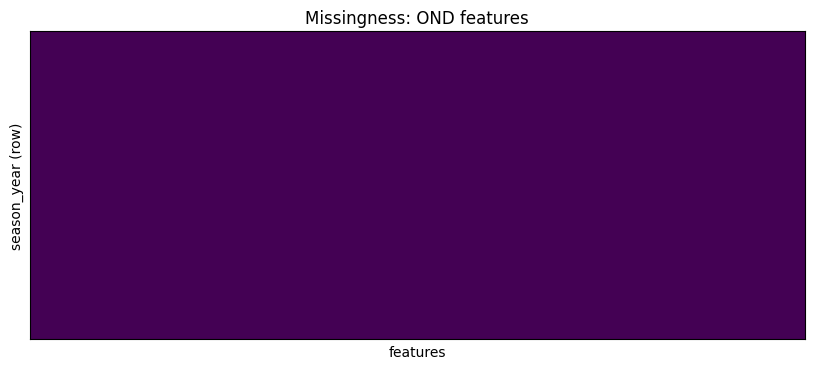

In [72]:
plot_missingness(features_OND_all_plus, "Missingness: OND features")


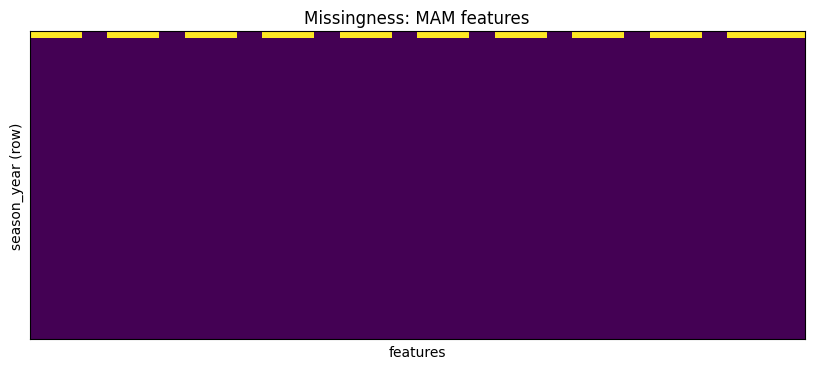

In [73]:
plot_missingness(features_MAM_all_plus, "Missingness: MAM features")
